# Meta Analysis
![](./images/Module5/Module5.jpg)


Meta pathway analysis using multiple omics data is a rapidly emerging field in bioinformatics and systems biology that allows for the integration of diverse omics data from genomics, transcriptomics, proteomics, metabolomics, and other molecular biology disciplines. By integrating multiple omics data, meta pathway analysis aims to provide a comprehensive understanding of the cellular functions and molecular mechanisms underlying biological processes in a given organism. This approach offers a powerful means to investigate the complex interplay between genes, proteins, and metabolites in different biological contexts, such as disease states or environmental conditions. Moreover, meta pathway analysis can identify key regulatory pathways and molecular signatures that are critical for the development of targeted therapeutics and precision medicine. Overall, the integration of multiple omics data through meta pathway analysis has the potential to reveal new insights into the underlying biology of complex diseases and to guide the development of personalized treatments. In this submodule we will demonstrate the power of meta analysis to find the significant pathways for Alzheimer and Parkinson diseases.

## Learning Objectives:
1. Downloading processed data
2. Performing enrichment analysis using FGSEA and plotting results
3. Performing meta-analysis and plotting results

In [1]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule5.html" width=100% height=250></iframe>')

<!DOCTYPE html>
 
 
 

 Quiz_Submodule5

## Loading Datasets
In this submodule 5 we will use datasets available from the Gene Expression Omnibus (GEO) repository. The datasets analyzed for Alzheimer disease is available under accession number `GSE5281`. This dataset contains genes that are preferentially expressed during the course of Alzheimer’s disease (AD) collected from 5 different brain regions: 1) entorhinal cortex (EC) 2) hippocampus (HIP) 3) medial temporal gyrus (MTG) 4) posterior cingulate 5) superior frontal gyrus and 6) primary visual cortex. In this submodule, we will perform analysis using data generated from EC, HIP, and MTG.

The datasets analyzed for Parkinson disease is available under accession numbers `GSE99039` and `GSE20292`. The first dataset contains 558 blood-based gene signature characterizing Idiopathic Parkinson's disease while the second dataset has 29 transcriptional analysis of whole substantia nigra in Parkinson's disease. Users can follow instruction provided in submodule 1 and 2 to download and perform genes ID mapping. In this submodule, we will load the preprocessed data store in the course's NIGMS Google bucket to perform analysis. The code to load all datasets is presented as follows:

In [7]:
# A vector to store all data IDs
data.IDs <- c("GSE5281-EC", "GSE5281-HIP", "GSE5281-MTG", "GSE99039", "GSE20292")
# A loop to read data information and store into a list
allData <- lapply(data.IDs, function(id){
  f <- paste0( "https://storage.googleapis.com/nigms-sandbox/nosi-unr/", id, ".rds")
  if (!file.exists(f)) return(readRDS(url(f), "rb"))
  return(NULL)
})

## Installing Required Libraries
In this submodule we will install several libraries to perform enrichment analysis, meta analysis and visualization. We will install package `fgsea` to perform enrichment analysis. For visualization purpose, we will use `ggpubr` and `cowplot`. `ggpubr` provides a range of functions that enable users to create publication-ready plots, including barplots, box-plots, scatter plots, histograms, and heatmaps. `cowplot` provides ability to create custom layouts for complex multi-panel figures. The package includes functions for arranging plots in a grid, as well as for adding margins, padding, and labels. The package also includes features for aligning plots, adjusting font sizes and colors, and exporting plots to different file formats. To perform meta analysis, we will use `meta` R package which provides functions for conducting fixed-effect and random-effects meta-analyses, as well as for conducting sensitivity analyses, subgroup analyses, and meta-regression analyses. The package also provides tools for assessing the heterogeneity of the studies included in the analysis and for creating forest plots to visualize the results. Lastly, packages include `stringr` and `matrixStats` provide utility function to manipulate input matrices. The package `fgsea` can be download from Bioconductor while other packages can be installed from CRAN. The code to install all packages are presented below:

In [8]:
suppressMessages({if (!require("BiocManager", quietly = TRUE))
    suppressWarnings(install.packages("BiocManager"))
    suppressWarnings(if (!require("fgsea")) BiocManager::install("fgsea", update = F))
})

In [9]:
suppressMessages({
  # Installing all packages
  suppressWarnings(if (!require("stringr")) install.packages("stringr"))
  suppressWarnings(if (!require("meta")) install.packages("meta"))
  suppressWarnings(if (!require("matrixStats")) install.packages("matrixStats"))
  suppressWarnings(if (!require("cowplot")) install.packages("cowplot"))
  suppressWarnings(if (!require("ggpubr")) install.packages("ggpubr"))
  suppressWarnings(if (!require("dplyr")) install.packages("dplyr"))
  suppressWarnings(if (!require("tidyr")) install.packages("tidyr"))

  # Loading all packages
  suppressPackageStartupMessages({library(fgsea)})
  suppressPackageStartupMessages({library(stringr)})
  suppressPackageStartupMessages({library(meta)})
  suppressPackageStartupMessages({library(matrixStats)})
  suppressPackageStartupMessages({library(cowplot)})
  suppressPackageStartupMessages({library(ggpubr)})
  suppressPackageStartupMessages({library(dplyr)})
  suppressPackageStartupMessages({library(tidyr)})
})

## Utility Function
To perform enrichment analysis we will need a helper function to obtain pathway information from KEGG database.
The `getKEGGGeneSet` shown below will access to KEGG database and download all the genesets for all the human pathways.
The result will be stored in a list.


In [10]:
getKEGGGeneSet <- function(org){
  # Get data from KEGG database and save to a data frame
  geneLink <- read.table(paste0("https://rest.kegg.jp/link/", org, "/pathway"),
                         sep = "\t", header = F,
                         stringsAsFactors = F);
  # Name the data columns
  colnames(geneLink) <- c("geneset", "gene")

  # Get genes for each geneset and store result in a list
  geneLink <- geneLink %>%
           group_by(geneset) %>%
          group_split() %>%
          lapply(function(dat){
    list(
      name = dat$geneset[1] %>% as.character(),
      genes = dat$gene %>% as.character()
    )
  })

  names(geneLink) <- geneLink %>% lapply(function(gl) gl$name)
  geneLink <- geneLink %>% lapply(function(gl) gl$genes)

  keeps <- geneLink %>% lapply(length) %>% unlist() %>% `>=`(5) %>% which() %>% names()
  geneLink <- geneLink[keeps]
  return(geneLink)
}

## Enrichment Analysis using FGSEA
In this section we will perform enrichment analysis using `fgsea` method for all methods.
FGSEA is an extension of the widely used Gene Set Enrichment Analysis (GSEA) method, which computes
an enrichment score for each gene set by comparing the distribution of genes in the set with the
 distribution of all genes. FGSEA, on the other hand, uses a fast algorithm to estimate the p-value
 for each gene set, based on the empirical distribution of the enrichment score obtained by permuting
 the gene labels in the ranked list.

The basic steps in performing FGSEA are as follows:

1. Rank the genes according to a certain metric, such as gene expression or differential expression.
2. Define a set of genes of interest, such as a pathway or a gene ontology term.
3. Compute the enrichment score for each gene set based on the ranks of its member genes in the ranked list.
4. Generate a null distribution of enrichment scores by permuting the gene labels in the ranked list.
5. Compute the p-value for each gene set by comparing its observed enrichment score with the null distribution.
6. Correct for multiple testing, for example, by using the false discovery rate (FDR) or the Bonferroni method.

To run the method `fgsea` we use permutation of 1,000 and signal-to-noise (SNR) is set to the ratio of differences
of mean and standard deviation between control and disease groups.
Now, we need to get the geneset and do parameter settings.

In [11]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule5-1.html" width=100% height=250></iframe>')

<!DOCTYPE html>
 
 
 

 Quiz_Submodule5-1

In [12]:
# Assign names to all datasets
names(allData) <- data.IDs
# Remove empty dataset
allData <- allData[!sapply(allData, is.null)]
# Get all human geneset
geneSet <- getKEGGGeneSet("hsa")
# Get uniuqte geneset
genes <- unique(unlist(geneSet))
# Parameter to set number of permutation
perm <- 1000

We can check the number of pathways for human using the following command:

In [13]:
print(paste0("The number of pathways is: ", length(geneSet)))

[1] "The number of pathways is: 346"


We can view the names of the first 10 pathways using the following command:


In [14]:
names(geneSet)[1:10]

[1] "path:hsa00010" "path:hsa00020" "path:hsa00030" "path:hsa00040"
 [5] "path:hsa00051" "path:hsa00052" "path:hsa00053" "path:hsa00061"
 [9] "path:hsa00062" "path:hsa00071"

We can view the name of first 10 genes of the first pathway using the following command:

In [15]:
geneSet$`path:hsa00010`[1:10]

[1] "hsa:10327"  "hsa:124"    "hsa:125"    "hsa:126"    "hsa:127"   
 [6] "hsa:128"    "hsa:130"    "hsa:130589" "hsa:131"    "hsa:160287"

Now, we can perform enrichment analysis for all datasets using the following script

In [16]:
allEnrichmentResult <- lapply(1:length(allData), function(iteration){
  # Set seed for reproducibilty
  set.seed(iteration)
  # Get the data
  data <- allData[[iteration]]
  data <- data[[1]]
  # Get expression matrix
  exprs <- data$expression
  # Get group information (control vs disease)
  group <- data$group
  annotation <- data$annotation
  exprs <- exprs[intersect(genes, rownames(exprs)), ]
  control.samples <- names(group[group == "c"])
  disease.samples <- names(group[group == "d"])
  exprs <- as.matrix(exprs)
  # Calculate signal to noise
  snr <- (rowMeans(exprs[, disease.samples]) -
           rowMeans(exprs[, control.samples]))/(rowSds(exprs[, disease.samples]) +
          rowSds(exprs[, control.samples]))
  # Perform enrichment analysis
  res <- suppressWarnings(fgsea(pathways = geneSet,
               stats = snr,
               nperm=perm))

  res$pvals$sample.size <- ncol(exprs)
  # Store result in a list
  list(
    id = names(allData)[iteration],
    data = data,
    res = res
  )
})
# Assign names using dataset ID for to the results
names(allEnrichmentResult) <- names(allData)

We can view the enrichment analysis result for the first dataset using the following command. The result is saved in a data frame in which the
first three columns contain pathway names, p-value, and adjusted p-value. The next column has Enrichment Score is calculated by walking down the ranked list of genes, and at each step, adding the running sum of the enrichment score for the gene set. The enrichment score is defined as the difference between the proportion of genes in the gene set that are up-regulated and the proportion of genes in the gene set that are down-regulated, multiplied by the degree of differential expression. The next column has Normalized Enrichment Score (NES) that takes into account both the enrichment of the gene set and its size, and it is normalized to correct for the multiple hypothesis testing performed in the analysis.

In the nex column, the NES score is calculated as the maximum deviation of the enrichment score from the expected null distribution, divided by the standard deviation of the scores of all possible permutations of the gene set labels. nMoreExtreme is a statistical metric to estimate the significance of the enrichment score of a gene set in a ranked list of genes. The "size" column of a gene set is an important factor that can affect the interpretation of the enrichment analysis results. The "leadingEdge" column is a subset of genes within a gene set that contribute most to the enrichment signal of the gene set in a ranked list of genes.

In [17]:
allEnrichmentResult$`GSE5281-EC`$res[1:10,]

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge,pvals
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<int>
path:hsa00010,0.25818182,0.44865145,-0.2413602,-1.1392367,141,65,"hsa:2597 , hsa:226 , hsa:5315 , hsa:92579, hsa:10327, hsa:7167 , hsa:3939 , hsa:2821 , hsa:5211 , hsa:3098 , hsa:5106 , hsa:5213 , hsa:5230 , hsa:8789 , hsa:2023 , hsa:2203 , hsa:2026 , hsa:219 , hsa:230 , hsa:55902, hsa:229 , hsa:2027 , hsa:5232 , hsa:26330, hsa:5236 , hsa:3101 , hsa:131 , hsa:218 , hsa:80201, hsa:124 , hsa:130 , hsa:83440, hsa:5160 , hsa:222",100
path:hsa00020,0.47609943,0.63848993,-0.2533863,-0.9572276,248,29,"hsa:3421, hsa:47 , hsa:1431",100
path:hsa00030,0.16826004,0.34287602,-0.3365079,-1.2712396,87,29,"hsa:2539 , hsa:226 , hsa:25796 , hsa:2821 , hsa:5211 , hsa:5213 , hsa:8277 , hsa:8789 , hsa:414328, hsa:2203 , hsa:230 , hsa:229 , hsa:7086",100
path:hsa00040,0.34960938,0.54735223,-0.2968775,-1.0635063,178,25,"hsa:6652 , hsa:27294, hsa:10327, hsa:54576, hsa:54658, hsa:55277, hsa:54578, hsa:54659, hsa:9942 , hsa:54600, hsa:54490, hsa:57016",100
path:hsa00051,0.01506591,0.06516008,-0.4205478,-1.6467445,7,33,"hsa:7264 , hsa:6652 , hsa:226 , hsa:5373 , hsa:7167 , hsa:29925, hsa:5211 , hsa:3098 , hsa:29926, hsa:5213 , hsa:5207 , hsa:5372 , hsa:3795 , hsa:8789 , hsa:55556, hsa:2203 , hsa:230 , hsa:229 , hsa:26007",100
path:hsa00052,0.64352720,0.77853291,-0.2252493,-0.8679854,342,31,"hsa:92579, hsa:5211 , hsa:3098 , hsa:2582 , hsa:2592 , hsa:5213",100
path:hsa00053,0.95744681,0.99106522,-0.1709827,-0.5931413,494,22,"hsa:10327, hsa:54576, hsa:54658, hsa:54578, hsa:54659, hsa:219 , hsa:54600, hsa:54490",100
path:hsa00061,0.54979253,0.70454895,0.2776840,0.9350247,264,17,"hsa:32 , hsa:84869, hsa:2180 , hsa:23305, hsa:51703, hsa:2181 , hsa:23205",100
path:hsa00062,0.12428298,0.27923320,-0.3722541,-1.3592691,64,26,"hsa:9524 , hsa:11332 , hsa:3033 , hsa:401494, hsa:117145, hsa:51495 , hsa:9200 , hsa:51144 , hsa:9374 , hsa:79071 , hsa:51102 , hsa:3030",100


We can select the significant pathways and calculate the statistics of NES scores. The result is stored in a list which contains the name of datasets (IDs), results of emrichment analysis generated from FGSEA method and statistics of NES score.

In [18]:
plots.enrichment.data <- allEnrichmentResult %>% lapply(function(data){
  plot.data <- data$res
  rownames(plot.data) <- plot.data$pathway
  plot.data$dataset <- data$id
  plot.data$NES.sd = abs((plot.data$NES - ifelse(plot.data$NES > 0, 1, -1))/qnorm(plot.data$pval))
  sd <- plot.data$NES.sd
  sd[sd > 0.5] <- 0.5

  plot.data$min <- plot.data$NES - sd*2
  plot.data$max <- plot.data$NES + sd*2

  plot.data$min[plot.data$min < -2.5] <- -2.5
  plot.data$max[plot.data$max > 2.5] <- 2.5

  # ES.df <- as.data.frame(do.call(cbind, data$res$NEs))
  ES.df <- as.data.frame(data$res$ES)
  rownames(ES.df) <- names(geneSet)

  list(
    id = data$id,
    res = plot.data,
    ES = ES.df
  )
})

To view the summary of NES scores for the first ten pathways in the first dataset, we can use the following command:

In [19]:
plots.enrichment.data$`GSE5281-EC`$res[1:10,c(1,11:13)]

pathway,NES.sd,min,max
<chr>,<dbl>,<dbl>,<dbl>
path:hsa00010,0.2145533,-1.56834325,-0.71013014
path:hsa00020,0.7135188,-1.95722759,0.04277241
path:hsa00030,0.2822285,-1.83569653,-0.70678263
path:hsa00040,0.1643642,-1.39223459,-0.73477792
path:hsa00051,0.2982653,-2.24327510,-1.05021390
path:hsa00052,0.3588299,-1.58564519,-0.15032566
path:hsa00053,0.2362989,-1.06573918,-0.12054346
path:hsa00061,0.5192326,-0.06497531,1.93502469
path:hsa00062,0.3113684,-1.98200588,-0.73653239


Next we can use `ggplot` library to visualize the NES scores of each pathway across all datasets.

In [20]:
# We will pick ten pathways for visualization
picked.pathways.names <- names(geneSet)[1:10]
# This is the main script to plot the enrichment score for each pathway. The scruipt
# will generate the plot for each dataset and store in a list
plts <- plots.enrichment.data %>% lapply(function(data){
  # Set the title of each plot by the dataset name
  name_plot <- data$id
  # Get the data for ploting
  plot.data <- data$res
  # Get the data for picked pathways
  plot.data <- plot.data %>%
    filter(pathway %in% picked.pathways.names)
  # Plot the for each dataset
  ggplot(plot.data, aes(y = pathway, x = NES, xmin = min, xmax = max)) +  theme_minimal() +
    geom_vline(xintercept = c(-1,1), colour="#FA8072", linetype = "longdash") +
    geom_vline(xintercept = c(0), colour="black", linetype = "longdash") +
    geom_errorbarh(height=.1) + theme_bw() +
    geom_point(size = 1, color = "red") +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
          plot.margin = unit(c(5,5,5,5), "pt"),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
          axis.text.x = element_text(face = "bold", size = 12),
          axis.title.x = element_text(face = "bold", size = 12)) +
    labs(x = "NES", title = name_plot) +
    xlim(-2.5, 2.5)
})

After running the above script, we will get a list that contains the plots of five datasets. Now we can arrange the lot in one row using the `gridExtra` function available in the `cowplot` package.

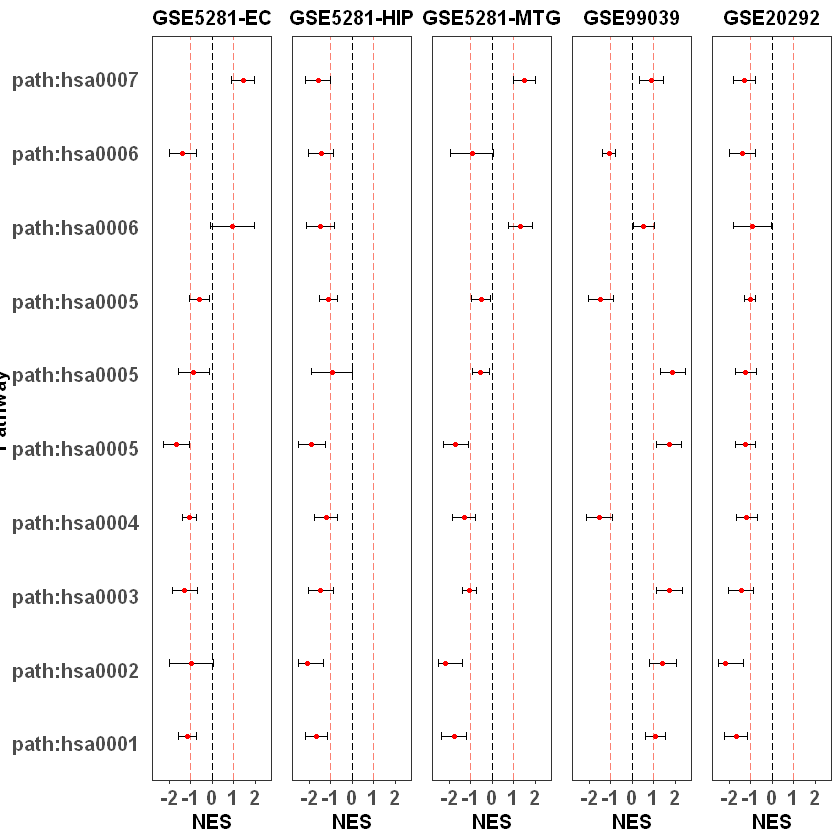

In [21]:
gridExtra::grid.arrange(grobs = c(
  list(
    ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +
            labs(y = "Pathway", title = "", x = "") +
            theme_minimal() +
      theme(panel.grid.major.x = element_blank(),
            plot.margin = unit(c(2,0,2,5), "pt"),
            axis.text = element_text(face = "bold", size = 12),
            axis.title.y = element_text(face = "bold", size = 12))
  ),
  plts
), nrow = 1, widths = c(1, rep(1, length(plts))))

The previous plot only shows the pathway score for each dataset. It does not provide us the overview for each disease. Therefore, we can plot overlay of enrichment plots for all datasets with the same disease (group) using the following script.

In [22]:
# Get the list of datasets that belong to one certain disease
groups <- list(
  "ALZHEIMER" = c("GSE5281-EC", "GSE5281-HIP", "GSE5281-MTG"),
  "PARKINSON" = c("GSE99039", "GSE20292")
)

# Combine the data
allCombinedData <- lapply(plots.enrichment.data, function(data) data$res)
allCombinedData <- as.data.frame(do.call(rbind, allCombinedData))
allCombinedData$disease <- "NA"
# Get the combine data for each group of disease
for (cat in names(groups)){
  allCombinedData$disease[allCombinedData$dataset %in% groups[[cat]]]  <- cat
}

allCombinedData <- allCombinedData %>% filter(pathway %in% picked.pathways.names)

# Plot the boxplot for each pathway using the combined data, the plot for
# each disease will be stored in a list. Here, we want to plot the NES scores for
# two diseases. Therefore, the result list will have two elements.

plts <- allCombinedData %>% group_by(disease) %>% group_split() %>% lapply(function(data){
  data$pathway <- factor(data$pathway,
                         levels = picked.pathways.names[length(picked.pathways.names):1])

  ggplot(data, aes(x=NES, y=pathway, group=dataset, col=dataset, fill=dataset)) +
    theme_minimal() +
    geom_point(position = position_dodge(0.7)) +
    geom_rect(
      aes(
        xmin=-Inf, xmax=Inf, ymin=as.numeric(pathway)-0.5, ymax=as.numeric(pathway)+0.5
      ),
      fill = ifelse((as.numeric(data$pathway)%%2 == 0), "white", "#eeeeee"),
      color = "white"
    ) +
    geom_point(position = position_dodge(0.7)) +
    geom_vline(xintercept = c(-1,1), colour="#FA8072", linetype = "longdash") +
    geom_vline(xintercept = c(0), colour="grey", linetype = "solid") +
    geom_errorbarh(height=.3, aes(xmin = min, xmax = max), position = position_dodge(0.7)) +
          theme_bw() +
    xlim(-2.5, 2.5) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
          plot.margin = unit(c(5,5,5,5), "pt"),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
          axis.text.x = element_text(face = "bold", size = 12),
          axis.title.x = element_text(face = "bold", size = 12),
          legend.position="top",
          legend.title = element_blank(),
          legend.text = element_text(face = "bold", size = 10)) +
    guides(color=guide_legend(ncol=1)) +
    labs(title = data$disease[1])
})

plotsAllLegends <- list()
plotsAllTitles <- list()

for(j in 1:length(plts)){
  p <- plts[[j]]
  legendP <- get_legend(p)
  titleP <- get_title(p)

  plotsAllLegends[[j]] <- legendP
  plotsAllTitles[[j]] <- titleP
}


plotsWithoutLegend <- lapply(plts, function(plt){
  plt <- plt + theme(legend.position = "none",
                     title = element_blank(),
                     plot.title = element_blank())
})

gs_titles <- lapply(plotsAllTitles, function(p)
  as_ggplot(p) + theme(
    legend.margin=margin(c(0,0,0,0))))

gs_legends <- lapply(plotsAllLegends, function(p)
  as_ggplot(p) + theme(
    legend.margin=margin(c(0,0,0,0))))

listAll <- c(gs_titles, gs_legends, c(
  list(
    ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +
            labs(y = "Pathway", title = "", x = "") + theme_minimal() +
      theme(panel.grid.major.x = element_blank(),
            plot.margin = unit(c(2,0,2,5), "pt"),
            axis.text = element_text(face = "bold", size = 12),
            axis.title.y = element_text(face = "bold", size = 12))
  ),
  plotsWithoutLegend
))

After getting the plot for each disease, we can arrange the plots in one row using the `gridExtra` function available in the `cowplot` package.

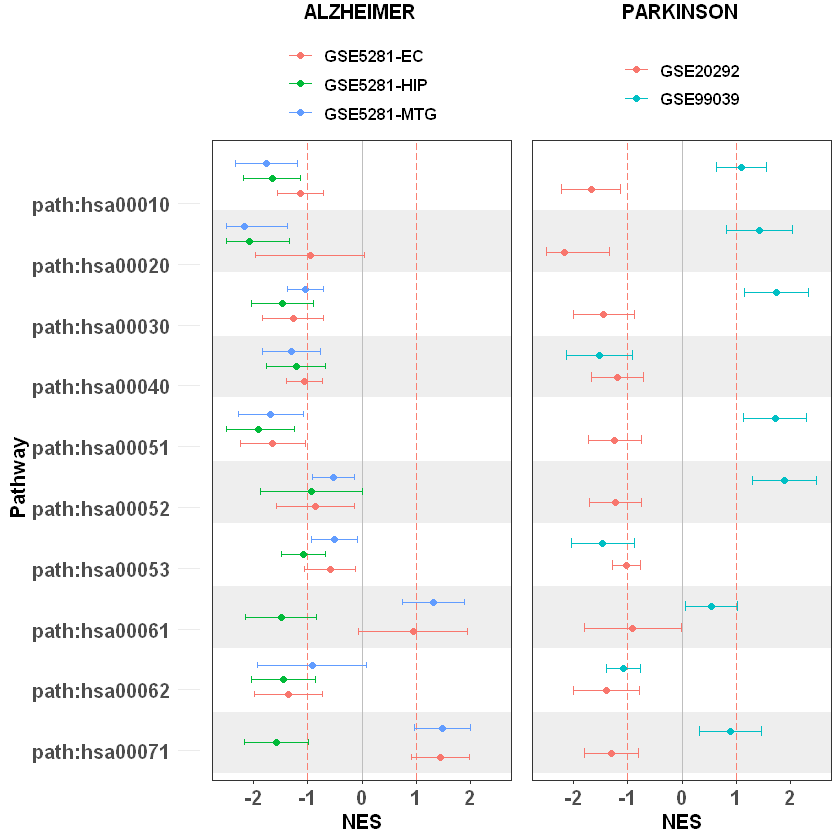

In [23]:
gridExtra::grid.arrange(
  grobs = listAll,
  widths = c(5, rep(8,2)),
  heights = c(0.4, 1.1, 8),
  layout_matrix = rbind(c(NA, rep(1:2)),
                        c(NA, rep(3:4)),
                        c(rep(5:7)))
)

From the figure above, we see that the same pathway in different datasets has different enrichment scores. The score might be significant in one dataset but it is not significant in other datasets. Therefore, it is necessary to perform meta-analysis to increase the statistical power of each pathway.

## Meta Analysis
In this section we will perform generic inverse variance meta-analysis using `metagen` function available in the `meta` package. `metagen` is a statistical method used in meta-analysis to combine the results of multiple studies that have measured the same effect size, typically using different sample sizes and study designs. This method involves pooling the effect sizes from each study, weighted by the inverse of their variance, in order to obtain an overall estimate of the effect size and its confidence interval.

The basic idea behind the generic inverse variance meta-analysis is that studies with larger sample sizes, which tend to have smaller variance, should be given more weight in the meta-analysis than studies with smaller sample sizes, which tend to have larger variance. This is achieved by weighting each study's effect size estimate by the inverse of its variance, which is a measure of the precision of the estimate.

The generic inverse variance meta-analysis is often used in meta-analyses of randomized controlled trials or observational studies, where the effect size is typically reported as a mean difference or a standardized mean difference between two groups, or as a hazard ratio or odds ratio for a binary outcome. This method assumes that the effect size estimates from each study are independent and normally distributed around the true effect size, and that there is no systematic bias or heterogeneity in the effect size estimates across studies.

In [24]:
# Get combined data
allCombinedData <- lapply(plots.enrichment.data, function(data) data$res)
allCombinedData <- as.data.frame(do.call(rbind, allCombinedData))
allCombinedData$disease <- "NA"

for (cat in names(groups)){
  allCombinedData$disease[allCombinedData$dataset %in%
                                  groups[[cat]]]  <- cat
}

#Performing meta analysis on groups of datasets with the same disease
metaESRes <- allCombinedData %>%
         group_by(disease, pathway) %>%
        group_split() %>%
        lapply(function(data){
  data <- drop_na(data)

  res <-  suppressWarnings(meta::metagen(data = data,
                       studlab = pathway,
                       TE = NES ,
                       seTE =NES.sd,
                       sm = "SMD",
                       n.e = NULL,
                       #n.e = sample.size,
                       method.tau = "REML",
                       hakn = TRUE))

  NES.combined <- res$TE.fixed
  NES.combined.sd <- res$seTE.fixed

  pval <- pnorm((ifelse(NES.combined > 0, 1, -1) - NES.combined)/NES.combined.sd)
  if (NES.combined < 0) pval <- 1 - pval

  data.frame(
    disease = data$disease[1],
    pathway = data$pathway[1],
    NES.combined = NES.combined,
    NES.combined.sd = NES.combined.sd,
    pval.combined = pval,
    count = nrow(data),
    stringsAsFactors = F
  )
}) %>% do.call(what = rbind) %>% as.data.frame()

After we perform meta-analysis we can calculate the adjust p-value me meta enrichment scores. We will use function `p.adjust` to calcuate adjust P-values for multiple comparisons. The result is save into a data frame.

In [26]:
#Computing adjusted meta p-values
metaESRes <- metaESRes %>%
         group_by(disease) %>%
        group_split() %>%
        lapply(function(r){
  r$p.fdr <- p.adjust(r$pval.combined, method = "fdr")
  r
}) %>% do.call(what = rbind)

We can plot meta analysis result using the script that we have developed previously.

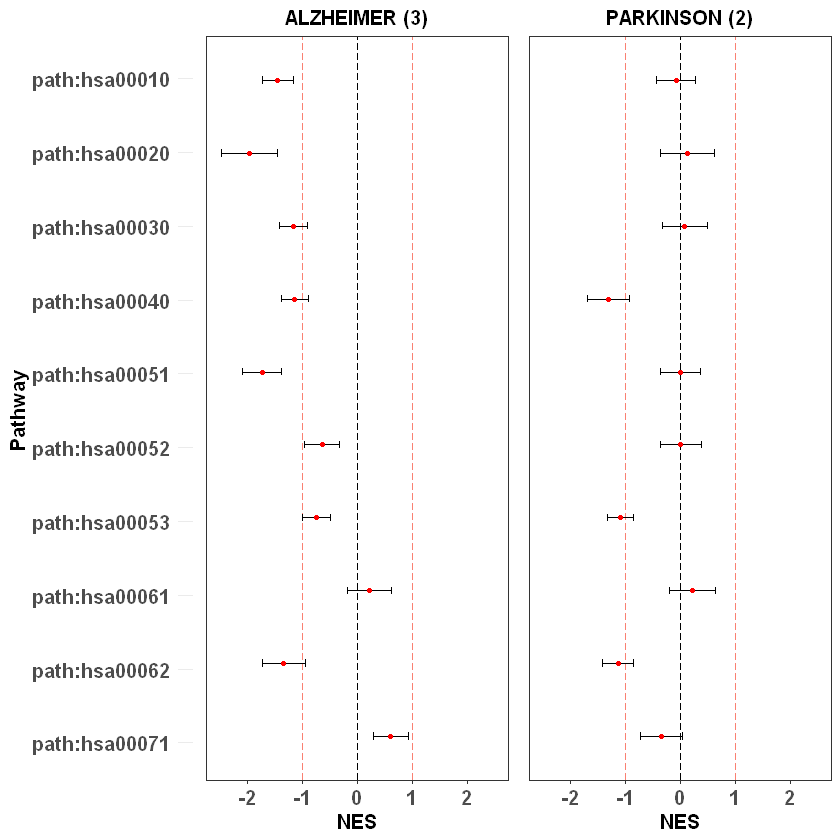

In [27]:
plts <- metaESRes %>% group_by(disease) %>% group_split() %>% lapply(function(plotDat){
  plotDat <- data.frame(plotDat)
  rownames(plotDat) <- plotDat$pathway
  plotDat <- plotDat[picked.pathways.names, ]
  plotDat$pathway <- factor(plotDat$pathway,
                            levels = picked.pathways.names[length(picked.pathways.names):1])

  sd <- plotDat$NES.combined.sd
  sd[sd > 0.5] <- 0.5

  plotDat$min <- plotDat$NES.combined - sd*2
  plotDat$max <- plotDat$NES.combined + sd*2

  plotDat$min[plotDat$min < -2.5] <- -2.5
  plotDat$max[plotDat$max > 2.5] <- 2.5

  ggplot(plotDat, aes(y = pathway, x = NES.combined, xmin=min, xmax = max)) +
          theme_minimal() +
    geom_vline(xintercept = c(-1,1), colour="#FA8072", linetype = "longdash") +
    geom_vline(xintercept = c(0), colour="black", linetype = "longdash") +
    geom_errorbarh(height=.1) + theme_bw() +
    geom_point(size = 1, color = "red") +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
          plot.margin = unit(c(5,5,5,5), "pt"),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
          axis.text.x = element_text(face = "bold", size = 12),
          axis.title.x = element_text(face = "bold", size = 12)) +
    labs(x = "NES", title = paste0(plotDat$disease[1], " (",plotDat$count[1],")")) +
    xlim(-2.5, 2.5)
})

gridExtra::grid.arrange(grobs = c(
  list(
    ggplot(plts[[1]]$data, aes(y = pathway, x = "")) +
            labs(y = "Pathway", title = "", x = "") +
            theme_minimal() +
      theme(panel.grid.major.x = element_blank(),
            plot.margin = unit(c(2,0,2,5), "pt"),
            axis.text = element_text(face = "bold",
                                     size = 12),
            axis.title.y = element_text(face = "bold", size = 12))
  ),
  plts
), nrow = 1, widths = c(0.6, rep(1, length(plts))))


From the above figure we see that the enrichment scores produced from meta-analysis using multiple datasets are more significant compared with the ones calculated them from a single dataset.


## Conclusion
In this course, we have successfully completed pathway analysis using omics data using five sub-modules that cover different aspects of bioinformatics analysis. The first sub-module, Data Processing, teaches the fundamental concepts of preprocessing and quality control of microarray data obtained from Gene Expression Omnibus. The second sub-module, Differential Expression Analysis, focuses how to analyze gene expression data to identify genes that are differentially expressed between two or more conditions. The third sub-module, Gene Set and Pathway shows us how to use different R library to obtain pathways and GO terms with associated gene list. The fourth sub-module, Enrichment Analysis, focuses on the identification of enriched biological pathways or functional categories within a set of genes of interest. Finally, the fifth sub-module, Meta Analysis, teaches the techniques of meta-analysis which is a statistical approach to combine the results of multiple independent studies. Overall, the cloud learning module provides a comprehensive and practical guide for researchers to analyze and interpret their genomic data using various bioinformatics tools and techniques.
